In [3]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

def load_images_from_folder(folder):
    images = []
    for filename in sorted(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

def compute_optical_flow(image1, image2):
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    return flow

train_images = load_images_from_folder(r'C:\Users\vashi\OneDrive\Desktop\video_dat\archive (2)\UCSD_Anomaly_Dataset.v1p2\UCSDped1\Train\Train001')
test_images = load_images_from_folder(r'C:\Users\vashi\OneDrive\Desktop\video_dat\archive (2)\UCSD_Anomaly_Dataset.v1p2\UCSDped1\Test\Test001')

train_flows = [compute_optical_flow(train_images[i], train_images[i+1]) for i in range(len(train_images)-1)]
test_flows = [compute_optical_flow(test_images[i], test_images[i+1]) for i in range(len(test_images)-1)]

print(f"Loaded {len(train_images)} training images and {len(test_images)} testing images.")
print(f"Computed {len(train_flows)} training flows and {len(test_flows)} testing flows.")


Loaded 200 training images and 200 testing images.
Computed 199 training flows and 199 testing flows.


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_st_caae(input_shape):
    input_img = layers.Input(shape=input_shape)
    
    # Encoder
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    # Bottleneck
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    # Decoder
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(input_shape[2], (3, 3), activation='sigmoid', padding='same')(x)
    
    return models.Model(input_img, decoded)

input_shape = (train_flows[0].shape[0], train_flows[0].shape[1], 2)
st_caae = build_st_caae(input_shape)
st_caae.compile(optimizer='adam', loss='mse')
st_caae.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 158, 238, 2)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 158, 238, 64)        │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 79, 119, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 79, 119, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 40, 60, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 40, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 20, 30, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 40, 60, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 40, 60, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 80, 120, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 80, 120, 64)         │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 160, 240, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 160, 240, 2)         │           1,154 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,330,306 (5.07 MB)

 Trainable params: 1,330,306 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
train_flows = np.array(train_flows)
test_flows = np.array(test_flows)

st_caae.fit(train_flows, train_flows, epochs=50, batch_size=32, validation_data=(test_flows, test_flows))


Epoch 1/50


ValueError: Dimensions must be equal, but are 158 and 160 for '{{node compile_loss/mse/sub}} = Sub[T=DT_FLOAT](data_1, functional_1_1/conv2d_6_1/Sigmoid)' with input shapes: [?,158,238,2], [?,160,240,2].

In [9]:
def load_and_resize_images_from_folder(folder, size=(160, 240)):
    images = []
    for filename in sorted(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, size)
            images.append(img)
    return images

train_images = load_and_resize_images_from_folder(r'C:\Users\vashi\OneDrive\Desktop\video_dat\archive (2)\UCSD_Anomaly_Dataset.v1p2\UCSDped1\Train\Train001')
test_images = load_and_resize_images_from_folder(r'C:\Users\vashi\OneDrive\Desktop\video_dat\archive (2)\UCSD_Anomaly_Dataset.v1p2\UCSDped1\Test\Test001')

train_flows = [compute_optical_flow(train_images[i], train_images[i+1]) for i in range(len(train_images)-1)]
test_flows = [compute_optical_flow(test_images[i], test_images[i+1]) for i in range(len(test_images)-1)]

train_flows = np.array(train_flows)
test_flows = np.array(test_flows)


In [11]:
def build_st_caae(input_shape):
    input_img = layers.Input(shape=input_shape)
    
    # Encoder
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    # Bottleneck
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    # Decoder
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(input_shape[2], (3, 3), activation='sigmoid', padding='same')(x)
    
    return models.Model(input_img, decoded)

input_shape = (train_flows[0].shape[0], train_flows[0].shape[1], 2)
st_caae = build_st_caae(input_shape)
st_caae.compile(optimizer='adam', loss='mse')
st_caae.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 240, 160, 2)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 240, 160, 64)        │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 120, 80, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 120, 80, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 60, 40, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 60, 40, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 20, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 30, 20, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 60, 40, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 60, 40, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 120, 80, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 120, 80, 64)         │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_5 (UpSampling2D)       │ (None, 240, 160, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 240, 160, 2)         │           1,154 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,330,306 (5.07 MB)

 Trainable params: 1,330,306 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
st_caae.fit(train_flows, train_flows, epochs=50, batch_size=32, validation_data=(test_flows, test_flows))


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - loss: 0.2418 - val_loss: 0.1068
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step - loss: 0.0959 - val_loss: 0.1068
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 6s/step - loss: 0.0936 - val_loss: 0.1068
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - loss: 0.0937 - val_loss: 0.1068
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - loss: 0.0934 - val_loss: 0.1068
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - loss: 0.0937 - val_loss: 0.1068
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - loss: 0.0929 - val_loss: 0.1068
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - loss: 0.0919 - val_loss: 0.1068
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step - loss: 0.0917 - val_loss: 0.1068
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - loss: 0.0888 - val_loss: 0.1068
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - loss: 0.0975 - val_loss: 0.1068
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 6s/step - loss: 0.0961 - val_loss: 0.1068
Epoch 13/50
7

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
Detected 12 anomalies out of 199 frames.
Detected anomalies in the following frames:


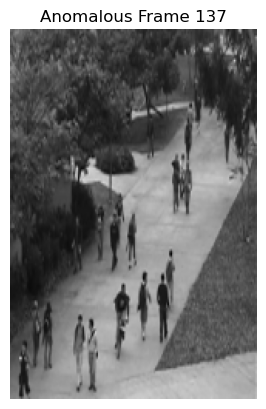

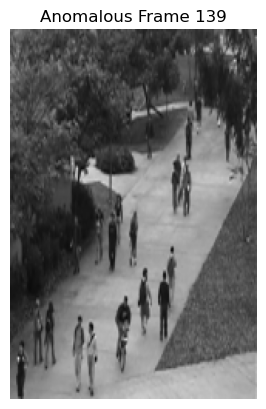

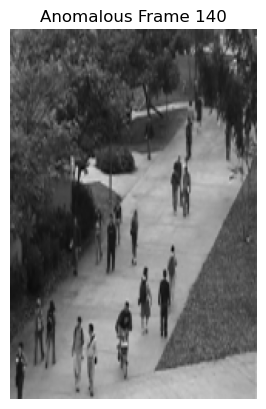

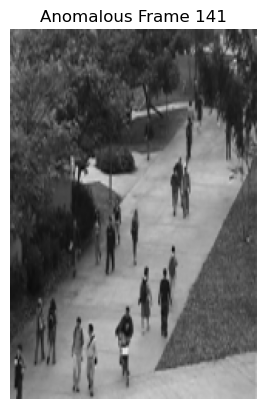

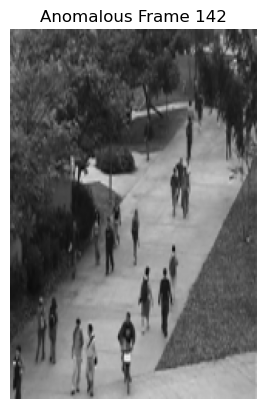

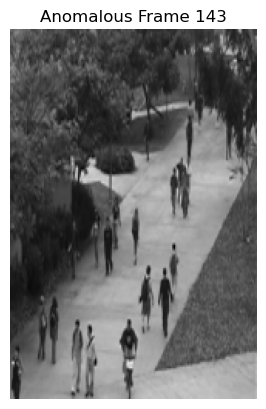

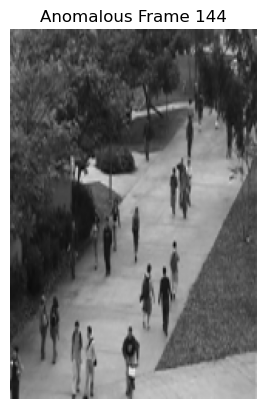

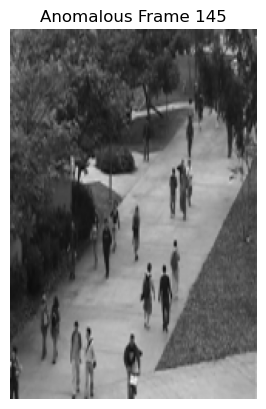

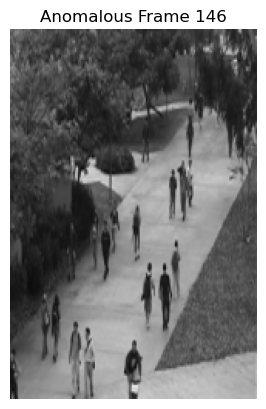

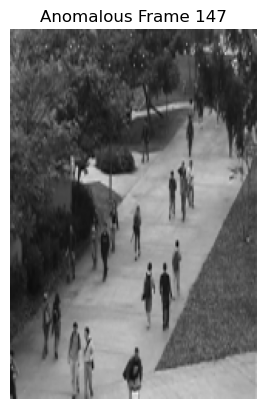

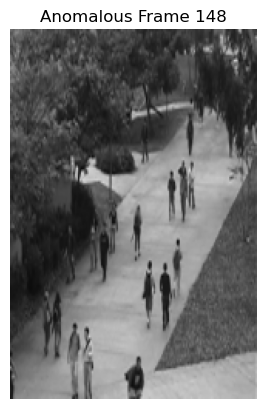

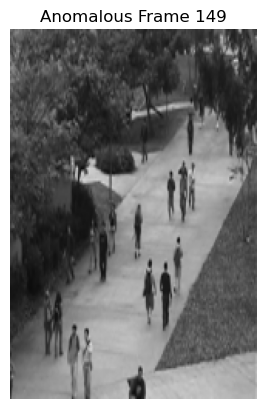

In [15]:
def evaluate_reconstruction_error(model, test_flows):
    reconstructions = model.predict(test_flows)
    errors = np.mean(np.square(test_flows - reconstructions), axis=(1, 2, 3))
    return errors

test_errors = evaluate_reconstruction_error(st_caae, test_flows)
threshold = np.mean(test_errors) + 2 * np.std(test_errors)
anomalies = test_errors > threshold

print(f"Detected {np.sum(anomalies)} anomalies out of {len(anomalies)} frames.")

def show_image(image, title='Image'):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

anomalous_indices = np.where(anomalies)[0]

print("Detected anomalies in the following frames:")
for idx in anomalous_indices:
    show_image(test_images[idx], title=f'Anomalous Frame {idx+1}')


In [17]:
def evaluate_accuracy(anomalies, ground_truth):
    predictions = anomalies.astype(int)
    accuracy = np.mean(predictions == ground_truth)
    return accuracy

# Assuming ground_truth is a list of 0s (normal) and 1s (anomalous) for test images
# Replace the following with your actual ground truth labels
ground_truth = [0] * len(test_flows)  # Placeholder, replace with actual labels

accuracy = evaluate_accuracy(anomalies, ground_truth)
print(f"Model accuracy: {accuracy * 100:.2f}%")


Model accuracy: 93.97%
